TO DO:

Need to be able to scatter plot measured values of Psi on top of the current Psi plot.

Alpha and rho LaTeX not working in plots.

Legend needs to be move in the Psi plot.

Consider also applying the scatter of the data and curve fit style of plotting for the parameters

Plots in general need to look better

LaTeX in all of the equations

In [1]:
import numpy as np
from scipy.integrate import quad, dblquad
%matplotlib inline
import matplotlib.pyplot as plt

This notebook calculates and plots the theoretical tilt angles. It will also plot the alpha and p0 factors vs temperature that are given in the cell below this.

# Material Characteristics

In [2]:
thetamin = 25.6*np.pi/180
thetamax = 33.7*np.pi/180
t = 4*10**-6 #Cell Thickness

# Data

In [3]:
tempsC = np.array([26, 27, 29, 31, 33, 35, 37])
voltages = np.array([2,3,6,7,9,11,12.5,14,16,18,20,22,23.5,26,27.5,29,31,32.5,34,36])
alpha_micro = np.array([.2575,.2475,.2275,.209,.189,.176,.15])
p0Debye = np.array([650,475,300,225,160,125,100])  #Temperature Increases to the right

In [16]:
#This Block just converts units

fields = np.array([entry/t for entry in voltages])

debye = 3.33564e-30
p0_array = np.array([entry*debye for entry in p0Debye]) #debye units to SI units

k = 1.3806488e-23
p0k_array = np.array([entry/k for entry in p0_array]) #p0k is used because it helps with the integration

KC = 273.15
tempsK = np.array([entry+KC for entry in tempsC]) #Celsius to Kelvin

alpha_array = np.array([entry*1e-6 for entry in alpha_micro])

# Langevin-Debye Model

$$ U(\theta,\phi) = -\rho_0E\:sin\:\theta\:cos\:\theta\:(1+\alpha E\:cos\:\phi) $$

# First, Calculate the Boltzmann Factor and the Partition Function

$$ {Boltz() returns:}\:\: e^{\frac{-U}{k_bT}}\:sin\:{\theta}\ $$

In [5]:
def Boltz(theta,phi,T,p0k,alpha,E):
    """Compute the integrand for the Boltzmann factor.
    Returns
    -------
    A function of theta,phi,T,p0k,alpha,E to be used within dblquad
    """
    return np.exp((1/T)*p0k*E*np.sin(theta)*np.cos(phi)*(1+alpha*E*np.cos(phi)))*np.sin(theta)

$$ Z(\theta,\phi,U) = \int_{\theta_{min}}^{\theta_{max}} \int_0^{2\pi} e^{\frac{-U}{k_bT}}\:sin\:{\theta}\: d\theta d\phi $$

In [6]:
def Z_func(T,p0k,alpha,E,thetamin,thetamax):
    """Compute the Boltzmann factor by using dblquad to double integrate for a set of conditions.
    Returns
    -------
    Float :
        The Boltzmann factor, Z, at theta,phi,T,p0k,alpha,E
    """

    Z, Z_error = dblquad(Boltz, 0, 2*np.pi,lambda theta: thetamin, lambda theta: thetamax,args=(T,p0k,alpha,E))

    return Z

# Second, Calculate the Tilt Angle $\psi$

$$ {psifunc() returns:   } \frac{sin\:{2\theta}\:cos\:{\phi}}{{cos}^2{\theta} - {sin}^2{\theta}\:{cos}^2{\phi}}\:e^{\frac{-U}{k_bT}}\:sin{(\theta}) $$

In [25]:
def psi_func(theta,phi,T,p0k,alpha,E):
    """Compute the integrand for use in our <tan(2psi)> equation.
    Returns
    -------
    X(theta,phi)*exp(-U/kT)
    A function of theta,phi,T,p0k,alpha,E to be used within dblquad
    """
    numerator = np.sin(2*theta)*np.cos(phi)

    denominator = (np.cos(theta)**2) - ((np.sin(theta)**2) * (np.cos(phi)**2))

    boltz = Boltz(theta,phi,T,p0k,alpha,E)

    return (numerator/denominator)*boltz

$$ tan(2\psi) = \frac{1}{Z}\int_{\theta_{min}}^{\theta_{max}} \int_0^{2\pi} \frac{sin\:{2\theta}\:cos\:{\phi}}{{cos}^2{\theta} - {sin}^2{\theta}\:{cos}^2{\phi}}\:e^{\frac{-U}{k_bT}}\:sin{(\theta})\: d\theta d\phi $$

In [18]:
def compute_psi(T,p0k,alpha,E,thetamin,thetamax):
    """Computes the tilt angle(psi) by use of our tan(2psi) equation
    Returns
    -------
    Float:
    The statistical tilt angle with conditions T,p0k,alpha,E
    """
    
    tan2psi, tan2psi_error = dblquad(psi_func, 0, 2*np.pi, lambda theta: thetamin, lambda theta: thetamax,args=(T,p0k,alpha,E))
    
    Z = Z_func(T,p0k,alpha,E,thetamin,thetamax)
    
    psi = np.arctan(tan2psi / Z) * (180 /(2*np.pi)) #Converting to degrees from radians and divide by two
    
    return psi

# Construct an Array of all Computed Tilt Angles

In [19]:
def psi_all(tempsK,fields,alpha_array,p0k_array,thetamin,thetamax):
    """Constructs an array where each entry in the array is an array of computed Psis at a Temperature.
    
    Parameters/Conditions
    ----------
    theta: 
        Tilt Angle
    phi:
        Azimuthal Angle
    T:
        Temperature
    p0k:
        Dipole moment p0/k. Where k is Boltzmann's constant
    alpha:
        Tilt Susceptibility
    E:
        Applied Electric Field
        
    Returns
    -------
    Array: M Dimensional Entry with N entries. Where N is the number of Applied Electric Fields. 
    M is the number of Temperatures.
    """
    
    def psi_array(T,p0k,alpha,fields,thetamin,thetamax):
        """Computes thes tilt angles(psi) from tan(2psi) for every electric field applied at a constant Temperature
        Returns
        -------
        Array: 1 Dimensional Entry with N entries. Where N is the number of Applied Electric Fields
        """
        Psi_Array = np.array([compute_psi(T,p0k,alpha,E,thetamin,thetamax) for E in fields])
        return Psi_Array

    return np.array([psi_array(tempsK[i],p0k_array[i],alpha_array[i],fields,thetamin,thetamax) for i in range(len(tempsK))])

In [20]:
AllPsi_Array = psi_all(tempsK,fields,alpha_array,p0k_array,thetamin,thetamax)

# Plotting Tilt Angle Results

In [21]:
def plot_psi(AllPsi,voltages,tempsK):
    """ Sets up plotting visual settings and plots the computed Psi arrays at each temperature"""
    plt.figure(figsize=(9,6));
    for j in range(len(AllPsi)):
        name = str(int(tempsK[j]-273.15)) + '$^{\circ}$C'
        plt.plot(voltages,AllPsi[j],label = name );
    plt.title('Tilt Angle vs Electric Field');
    plt.xlabel('Applied Electric Field E/$\mu$m')
    plt.ylabel('Tilt Angle $\psi$')
    
    plt.xlim(0,voltages.max()+2)
    plt.ylim(0,AllPsi_Array[0].max()+2)
    plt.legend(loc=2)

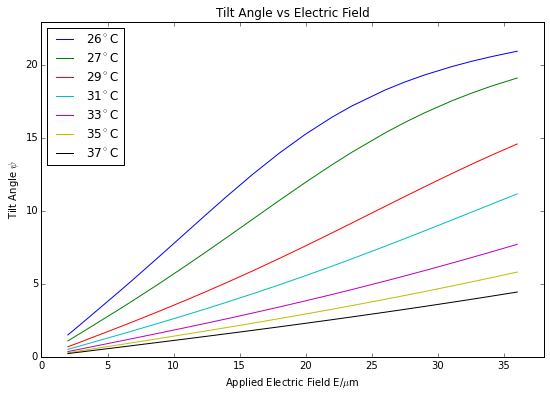

In [22]:
plot_psi(AllPsi_Array,voltages,tempsK)

# Plotting Parameters $\alpha$ and $\rho_0$

In [23]:
def plot_parameters(alpha_array,p0_array,tempsK):
    """ Sets up plotting visual settings and plots parameters alpha and p0 vs temperature"""
    tempsC = np.array([i-273 for i in tempsK])
    p0_debye = np.array([i/3.33e-30 for i in p0_array])
    alpha_um = np.array([i/1e-6 for i in alpha_array])

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,8));
    plt.sca(ax2);
    plt.scatter(tempsC,p0_debye);
    plt.title('Polarization Parameter vs Temperature');
    plt.xlabel('Temperature $^{\circ}$C');
    plt.ylabel('rho (debye)');

    plt.sca(ax1);
    plt.scatter(tempsC,alpha_um);
    plt.title('Alpha Parameter vs Temperature');
    plt.xlabel('Temperature $^{\circ}$C');
    plt.ylabel('alpha ($\mu$m/V)');
    plt.tight_layout();

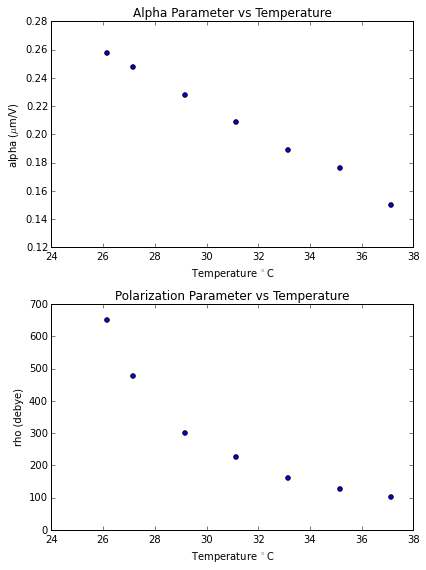

In [24]:
plot_parameters(alpha_array,p0_array,tempsK)